<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_LSTM/GRU_LSTM_Treasury10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 4.81 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Jul 19 17:56:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Treasury10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 7.5 MB/s 
     |████████████████████████████████| 97 kB 8.5 MB/s 
     |████████████████████████████████| 133 kB 66.8 MB/s 
     |████████████████████████████████| 138 kB 73.8 MB/s 
     |████████████████████████████████| 170 kB 75.0 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(GRU(units=64, activation=config.activation, return_sequences=True, input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 3
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: dky8p8xb
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_LSTM/sweeps/dky8p8xb


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: ico2pca0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
8/8 [==============================] - 26s 264ms/step - loss: 0.1601 - mean_squared_error: 0.1601 - mean_absolute_error: 0.3352 - val_loss: 0.0855 - val_mean_squared_error: 0.0855 - val_mean_absolute_error: 0.2701
Epoch 2/100
8/8 [==============================] - 1s 123ms/step - loss: 0.0397 - mean_squared_error: 0.0397 - mean_absolute_error: 0.1677 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0888
Epoch 3/100
8/8 [==============================] - 1s 111ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.1044 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1090
Epoch 4/100
8/8 [==============================] - 1s 108ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0717 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0866
Epoch 5/100
8/8 [==============================] - 1s 111ms/step - loss: 0.0054 - mean_squared_erro

epoch,99
loss,0.00157
mean_squared_error,0.00157
mean_absolute_error,0.03134
val_loss,0.00227
val_mean_squared_error,0.00227
val_mean_absolute_error,0.03701
_runtime,129
_timestamp,1626717552
_step,99
best_val_loss,0.00227


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vt0au5sy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 8s 158ms/step - loss: 0.1136 - mean_squared_error: 0.1136 - mean_absolute_error: 0.2839 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0797
Epoch 2/200
32/32 [==============================] - 4s 127ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0588 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0755
Epoch 3/200
32/32 [==============================] - 4s 123ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0543 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0773
Epoch 4/200
32/32 [==============================] - 4s 124ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0533 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0696
Epoch 5/200
32/32 [==============================] - 4s 113ms/step - loss: 0.0041 - mean_squ

epoch,80
loss,0.00167
mean_squared_error,0.00167
mean_absolute_error,0.03205
val_loss,0.00243
val_mean_squared_error,0.00243
val_mean_absolute_error,0.03912
_runtime,318
_timestamp,1626717920
_step,80
best_val_loss,0.00231


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▄▃▄▃▃▃▅▂▃▂▂▂▁▂▁▂▂▂▃▂▁▂▂▁▂▁▁▂▂▁▁▁▂▁▂▁
val_mean_squared_error,██▆▅▄▃▄▃▃▃▅▂▃▂▂▂▁▂▁▂▂▂▃▂▁▂▂▁▂▁▁▂▂▁▁▁▂▁▂▁
val_mean_absolute_error,██▆▆▄▄▄▃▃▃▅▂▃▂▂▂▂▂▂▂▂▂▃▂▁▂▂▁▂▁▁▂▂▁▁▁▂▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: w4zdgsqw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 7s 129ms/step - loss: 0.3062 - mean_squared_error: 0.3062 - mean_absolute_error: 0.4794 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0890
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0674 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1295
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0970 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1303
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0939 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1157
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0107 - mean_squared_error: 0.0107 

epoch,19
loss,0.00811
mean_squared_error,0.00811
mean_absolute_error,0.07641
val_loss,0.01301
val_mean_squared_error,0.01301
val_mean_absolute_error,0.09921
_runtime,13
_timestamp,1626717950
_step,19
best_val_loss,0.00619


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁
val_loss,▂▃▃▃▂█▅▂▇▁▃▄▂▃▄▃▃▁▂▂
val_mean_squared_error,▂▃▃▃▂█▅▂▇▁▃▄▂▃▄▃▃▁▂▂
val_mean_absolute_error,▂▄▄▃▃█▆▃▇▁▄▅▃▄▅▃▃▁▃▃
_runtime,▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅███
_timestamp,▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅███
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: qvuopfli with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 8s 142ms/step - loss: 1.3280 - mean_squared_error: 1.3280 - mean_absolute_error: 0.5508 - val_loss: 0.1025 - val_mean_squared_error: 0.1025 - val_mean_absolute_error: 0.3072
Epoch 2/100
32/32 [==============================] - 4s 117ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - mean_absolute_error: 0.1370 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0580
Epoch 3/100
32/32 [==============================] - 3s 109ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.1040 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0473
Epoch 4/100
32/32 [==============================] - 4s 115ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0867 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0630
Epoch 5/100
32/32 [==============================] - 4s 114ms/step - loss: 0.0120 - mean_squ

epoch,58
loss,0.00159
mean_squared_error,0.00159
mean_absolute_error,0.03156
val_loss,0.00355
val_mean_squared_error,0.00355
val_mean_absolute_error,0.04946
_runtime,232
_timestamp,1626718189
_step,58
best_val_loss,0.00173


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▂▃▂▁▄▁▂▂▂▂▂▁▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pvvta1uj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 7s 179ms/step - loss: 0.1047 - mean_squared_error: 0.1047 - mean_absolute_error: 0.2592 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0772
Epoch 2/50
16/16 [==============================] - 2s 116ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0848 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0582
Epoch 3/50
16/16 [==============================] - 2s 121ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0544 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0532
Epoch 4/50
16/16 [==============================] - 2s 119ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0472 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0531
Epoch 5/50
16/16 [==============================] - 2s 123ms/step - loss: 0.0035 - mean_squared_

epoch,49
loss,0.00154
mean_squared_error,0.00154
mean_absolute_error,0.03087
val_loss,0.00269
val_mean_squared_error,0.00269
val_mean_absolute_error,0.03986
_runtime,104
_timestamp,1626718300
_step,49
best_val_loss,0.00218


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▃▂▁▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: h1itcwo5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 5s 49ms/step - loss: 0.1757 - mean_squared_error: 0.1757 - mean_absolute_error: 0.3397 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0782
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0605 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0750
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0567 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0740
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0521 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0701
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error:

epoch,49
loss,0.0017
mean_squared_error,0.0017
mean_absolute_error,0.03243
val_loss,0.00217
val_mean_squared_error,0.00217
val_mean_absolute_error,0.03699
_runtime,26
_timestamp,1626718334
_step,49
best_val_loss,0.00215


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▄▅▄▃▃▄▃▃▂▂▃▃▃▂▂▂▂▂▂▂▁▄▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▆▅▄▅▄▃▃▄▃▃▂▂▃▃▃▂▂▂▂▂▂▂▁▄▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▇▅▅▅▄▄▃▄▄▃▃▃▄▃▃▃▃▃▂▂▂▂▂▅▂▂▃▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8m43jnz3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 4s 136ms/step - loss: 0.1219 - mean_squared_error: 0.1219 - mean_absolute_error: 0.2625 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0936
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0730 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1325
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0783 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1119
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0812 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1013
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0072 - mean_squared_error: 0.0

epoch,43
loss,0.00301
mean_squared_error,0.00301
mean_absolute_error,0.0434
val_loss,0.00278
val_mean_squared_error,0.00278
val_mean_absolute_error,0.04087
_runtime,13
_timestamp,1626718357
_step,43
best_val_loss,0.0025


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▂▂▁▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁
val_loss,▅█▆▅▄▇▄▃▄▃▂▄▂▂▂▂▂▃▂▃▄▁▃▃▁▃▂▂▂▁▁▂▂▁▂▂▃▂▁▁
val_mean_squared_error,▅█▆▅▄▇▄▃▄▃▂▄▂▂▂▂▂▃▂▃▄▁▃▃▁▃▂▂▂▁▁▂▂▁▂▂▃▂▁▁
val_mean_absolute_error,▅█▆▆▄█▄▄▅▄▂▅▂▃▃▃▃▄▂▅▅▁▃▄▁▅▂▃▃▁▁▃▂▁▂▂▄▂▁▁
_runtime,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
_timestamp,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: flgsa3cy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 9s 153ms/step - loss: 0.1091 - mean_squared_error: 0.1091 - mean_absolute_error: 0.2459 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0926
Epoch 2/50
32/32 [==============================] - 4s 120ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0785 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0786
Epoch 3/50
32/32 [==============================] - 4s 113ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0685 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0726
Epoch 4/50
32/32 [==============================] - 4s 112ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0643 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0697
Epoch 5/50
32/32 [==============================] - 4s 117ms/step - loss: 0.0063 - mean_squared_

epoch,49
loss,0.00194
mean_squared_error,0.00194
mean_absolute_error,0.0351
val_loss,0.00228
val_mean_squared_error,0.00228
val_mean_absolute_error,0.0373
_runtime,201
_timestamp,1626718569
_step,49
best_val_loss,0.00212


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▃▆▃▂▃▂▂▃▄▂▂▂▂▂▁▁▂▂▁▃▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▃▆▃▂▃▂▂▃▄▂▂▂▂▂▁▁▂▂▁▃▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▄▄▇▄▃▃▃▃▄▅▂▂▂▂▂▂▂▃▂▂▃▂▁▂▃▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: odl5kaxa with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 5s 242ms/step - loss: 0.2585 - mean_squared_error: 0.2585 - mean_absolute_error: 0.4719 - val_loss: 0.2331 - val_mean_squared_error: 0.2331 - val_mean_absolute_error: 0.4663
Epoch 2/200
8/8 [==============================] - 1s 116ms/step - loss: 0.1069 - mean_squared_error: 0.1069 - mean_absolute_error: 0.2882 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0847
Epoch 3/200
8/8 [==============================] - 1s 110ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_error: 0.1144 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0751
Epoch 4/200
8/8 [==============================] - 1s 124ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0786 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1270
Epoch 5/200
8/8 [==============================] - 1s 120ms/step - loss: 0.0107 - mean_squared_error

epoch,88
loss,0.00258
mean_squared_error,0.00258
mean_absolute_error,0.04055
val_loss,0.00298
val_mean_squared_error,0.00298
val_mean_absolute_error,0.04253
_runtime,98
_timestamp,1626718683
_step,88
best_val_loss,0.00297


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: v6k02qud with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 5s 141ms/step - loss: 0.1180 - mean_squared_error: 0.1180 - mean_absolute_error: 0.2937 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0738
Epoch 2/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0621 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0698
Epoch 3/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0586 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0676
Epoch 4/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0551 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0682
Epoch 5/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0042 - mean_squared_error: 0.

epoch,181
loss,0.00146
mean_squared_error,0.00146
mean_absolute_error,0.02971
val_loss,0.00183
val_mean_squared_error,0.00183
val_mean_absolute_error,0.03363
_runtime,33
_timestamp,1626718724
_step,181
best_val_loss,0.0018


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▆▅▄▄▃▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▃▂▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁
mean_squared_error,█▆▅▄▄▃▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▃▂▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▄▅▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁
val_loss,█▆▇▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▂▁▃▁▁▁▁▁
val_mean_squared_error,█▆▇▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▂▁▃▁▁▁▁▁
val_mean_absolute_error,█▇▇▅▄▅▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▃▂▁▃▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: l0mopzo5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 8s 133ms/step - loss: 0.1505 - mean_squared_error: 0.1505 - mean_absolute_error: 0.3210 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0866
Epoch 2/200
32/32 [==============================] - 4s 120ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0699 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0867
Epoch 3/200
32/32 [==============================] - 4s 117ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0644 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0837
Epoch 4/200
32/32 [==============================] - 4s 119ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0650 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0888
Epoch 5/200
32/32 [==============================] - 4s 117ms/step - loss: 0.0052 - mean_squ

epoch,65
loss,0.00192
mean_squared_error,0.00192
mean_absolute_error,0.03461
val_loss,0.00319
val_mean_squared_error,0.00319
val_mean_absolute_error,0.04566
_runtime,262
_timestamp,1626719010
_step,65
best_val_loss,0.0025


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇█▄▄▄▄▅▃▃▃▂▄▂▂▃▂▂▂▂▂▃▂▂▄▂▁▁▁▂▁▂▁▁▁▁▂▁▃▂
val_mean_squared_error,▇▇█▄▄▄▄▅▃▃▃▂▄▂▂▃▂▂▂▂▂▃▂▂▄▂▁▁▁▂▁▂▁▁▁▁▂▁▃▂
val_mean_absolute_error,███▅▅▅▄▅▄▃▄▂▄▃▂▃▂▂▃▃▂▃▂▂▅▃▂▁▁▂▁▂▁▁▁▁▃▁▄▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: j6jkua17 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 5s 94ms/step - loss: 0.0928 - mean_squared_error: 0.0928 - mean_absolute_error: 0.2224 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0762
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0614 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0751
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0588 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0675
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0510 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0824
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0076 - mean_squared_error:

epoch,49
loss,0.00199
mean_squared_error,0.00199
mean_absolute_error,0.03476
val_loss,0.00212
val_mean_squared_error,0.00212
val_mean_absolute_error,0.03638
_runtime,18
_timestamp,1626719043
_step,49
best_val_loss,0.00212


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇▅█▄▄▄▃▆▃▃▃▂▃▂▃▆▃▅▂▃▃▂▂▅▂▂▁▁▁▂▂▂▁▁▁▂▁▁▁
val_mean_squared_error,▇▇▅█▄▄▄▃▆▃▃▃▂▃▂▃▆▃▅▂▃▃▂▂▅▂▂▁▁▁▂▂▂▁▁▁▂▁▁▁
val_mean_absolute_error,▇▇▆█▅▄▅▄▆▄▃▃▃▄▃▃▇▃▆▂▄▃▂▂▆▂▃▂▁▁▂▂▂▂▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: q0iqp39v with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 5s 258ms/step - loss: 0.1747 - mean_squared_error: 0.1747 - mean_absolute_error: 0.3648 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0841
Epoch 2/100
8/8 [==============================] - 1s 121ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0756 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1015
Epoch 3/100
8/8 [==============================] - 1s 123ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0836 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0816
Epoch 4/100
8/8 [==============================] - 1s 122ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0708 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0830
Epoch 5/100
8/8 [==============================] - 1s 116ms/step - loss: 0.0068 - mean_squared_error

epoch,41
loss,0.00347
mean_squared_error,0.00347
mean_absolute_error,0.04721
val_loss,0.00638
val_mean_squared_error,0.00638
val_mean_absolute_error,0.0636
_runtime,51
_timestamp,1626719114
_step,41
best_val_loss,0.00446


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▄▃▃▄▂█▂▂▂▂▂▇▂▅▂▆▂▂▂▂▁▃▃▁▁▁▁▁▁▁▁▃▁▁▁▁▁▂▂
val_mean_squared_error,▃▄▃▃▄▂█▂▂▂▂▂▇▂▅▂▆▂▂▂▂▁▃▃▁▁▁▁▁▁▁▁▃▁▁▁▁▁▂▂
val_mean_absolute_error,▃▅▃▃▄▃█▂▃▂▂▂▇▂▅▂▆▂▃▂▃▂▄▄▁▂▂▂▂▁▁▁▃▂▁▁▁▂▃▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: av6ke84c with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 6s 176ms/step - loss: 0.2218 - mean_squared_error: 0.2218 - mean_absolute_error: 0.4165 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1598
Epoch 2/200
16/16 [==============================] - 2s 118ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.1093 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0884
Epoch 3/200
16/16 [==============================] - 2s 105ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0650 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0793
Epoch 4/200
16/16 [==============================] - 2s 120ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0619 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0695
Epoch 5/200
16/16 [==============================] - 2s 124ms/step - loss: 0.0049 - mean_squ

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,57
loss,0.00241
mean_squared_error,0.00241
mean_absolute_error,0.03833
val_loss,0.00286
val_mean_squared_error,0.00286
val_mean_absolute_error,0.04176
_runtime,124
_timestamp,1626719248
_step,57
best_val_loss,0.00252


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nezz2yfc with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 5s 248ms/step - loss: 0.3199 - mean_squared_error: 0.3199 - mean_absolute_error: 0.4691 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1433
Epoch 2/50
8/8 [==============================] - 1s 123ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1623 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1651
Epoch 3/50
8/8 [==============================] - 1s 110ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absolute_error: 0.1093 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0849
Epoch 4/50
8/8 [==============================] - 1s 114ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0906 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1036
Epoch 5/50
8/8 [==============================] - 1s 133ms/step - loss: 0.0103 - mean_squared_error: 0.0

epoch,49
loss,0.00243
mean_squared_error,0.00243
mean_absolute_error,0.03855
val_loss,0.00356
val_mean_squared_error,0.00356
val_mean_absolute_error,0.04683
_runtime,60
_timestamp,1626719341
_step,49
best_val_loss,0.00356


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▂▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▂▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▃▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vdz251yf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 5s 205ms/step - loss: 0.1394 - mean_squared_error: 0.1394 - mean_absolute_error: 0.2950 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1576
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0878 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0895
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0691 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0564
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0588 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0758
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0041 - mean_squared_error: 0.00

epoch,130
loss,0.00101
mean_squared_error,0.00101
mean_absolute_error,0.02514
val_loss,0.00201
val_mean_squared_error,0.00201
val_mean_absolute_error,0.03541
_runtime,25
_timestamp,1626719405
_step,130
best_val_loss,0.00163


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: txmpc3ua with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 9s 151ms/step - loss: 0.0857 - mean_squared_error: 0.0857 - mean_absolute_error: 0.1866 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0937
Epoch 2/100
32/32 [==============================] - 4s 120ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0581 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0791
Epoch 3/100
32/32 [==============================] - 4s 126ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0497 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0586
Epoch 4/100
32/32 [==============================] - 4s 121ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0445 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0544
Epoch 5/100
32/32 [==============================] - 4s 119ms/step - loss: 0.0030 - mean_squ

epoch,73
loss,0.00122
mean_squared_error,0.00122
mean_absolute_error,0.02761
val_loss,0.00169
val_mean_squared_error,0.00169
val_mean_absolute_error,0.03153
_runtime,304
_timestamp,1626719720
_step,73
best_val_loss,0.00165


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▂▂▂▂▁▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▂▂▂▂▁▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▃▂▁▁▁▁▁▂▁▁▂▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kb0jjvtk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 5s 36ms/step - loss: 0.0628 - mean_squared_error: 0.0628 - mean_absolute_error: 0.1758 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0583
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0443 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0537
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0418 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0548
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0448 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0441
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0

epoch,46
loss,0.00118
mean_squared_error,0.00118
mean_absolute_error,0.02689
val_loss,0.0018
val_mean_squared_error,0.0018
val_mean_absolute_error,0.03296
_runtime,25
_timestamp,1626719779
_step,46
best_val_loss,0.00167


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▃▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▆▇▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▃▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▇▇▄▄▃▃▃▄▃▃▃▂▂▂▂▃▃▃▄▂▁▂▁▁▃▃▁▁▂▃▁▁▁▁▂▁▂▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ofhar0f3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 4s 37ms/step - loss: 0.1235 - mean_squared_error: 0.1235 - mean_absolute_error: 0.2786 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1098
Epoch 2/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0651 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0699
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0502 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0604
Epoch 4/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0460 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0589
Epoch 5/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_err

epoch,135
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.02657
val_loss,0.00172
val_mean_squared_error,0.00172
val_mean_absolute_error,0.03213
_runtime,57
_timestamp,1626719846
_step,135
best_val_loss,0.00164


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▅▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jtd09twn with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 6s 266ms/step - loss: 0.4387 - mean_squared_error: 0.4387 - mean_absolute_error: 0.4783 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0807
Epoch 2/50
8/8 [==============================] - 1s 134ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0618 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1037
Epoch 3/50
8/8 [==============================] - 1s 128ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0654 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0599
Epoch 4/50
8/8 [==============================] - 1s 135ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0492 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0769
Epoch 5/50
8/8 [==============================] - 1s 123ms/step - loss: 0.0046 - mean_squared_error: 0.0

epoch,49
loss,0.00147
mean_squared_error,0.00147
mean_absolute_error,0.03005
val_loss,0.00188
val_mean_squared_error,0.00188
val_mean_absolute_error,0.03391
_runtime,62
_timestamp,1626719919
_step,49
best_val_loss,0.00188


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▃▅▂▂▄▂▂▂▂▅▁▂▁▁▁▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▃▁▂▁
val_mean_squared_error,▅█▃▅▂▂▄▂▂▂▂▅▁▂▁▁▁▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▃▁▂▁
val_mean_absolute_error,▆█▄▅▃▃▄▂▂▂▃▆▂▃▂▂▂▃▂▃▃▂▂▁▁▁▂▁▂▁▁▂▁▁▁▁▄▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 53jjkcwy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 5s 108ms/step - loss: 0.1704 - mean_squared_error: 0.1704 - mean_absolute_error: 0.3591 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0802
Epoch 2/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0666 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0752
Epoch 3/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0556 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0737
Epoch 4/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0587 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0743
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0048 - mean_squared

epoch,199
loss,0.00129
mean_squared_error,0.00129
mean_absolute_error,0.02823
val_loss,0.00184
val_mean_squared_error,0.00184
val_mean_absolute_error,0.0336
_runtime,56
_timestamp,1626719989
_step,199
best_val_loss,0.00171


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▄▄▄▃▃▂▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▄▄▄▄▃▃▂▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁
val_loss,█▇▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: r0e0m56q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 4s 37ms/step - loss: 0.0665 - mean_squared_error: 0.0665 - mean_absolute_error: 0.1806 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0614
Epoch 2/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0442 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0447
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0408 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0441
Epoch 4/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0393 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0423
Epoch 5/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0023 - mean_squared_er

epoch,48
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.02677
val_loss,0.00172
val_mean_squared_error,0.00172
val_mean_absolute_error,0.03193
_runtime,26
_timestamp,1626720027
_step,48
best_val_loss,0.00166


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▂▂▂▂▂▂▁▃▁▁▂▁▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▂▂▂▂▂▂▁▃▁▁▂▁▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▃▃▃▂▂▃▂▂▃▂▂▃▁▂▂▁▂▂▁▃▂▁▁▁▁▁▁▁▃▂▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qfmwqskl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 9s 156ms/step - loss: 0.1557 - mean_squared_error: 0.1557 - mean_absolute_error: 0.3337 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.2125
Epoch 2/100
32/32 [==============================] - 4s 122ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1516 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0804
Epoch 3/100
32/32 [==============================] - 4s 121ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0881 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0866
Epoch 4/100
32/32 [==============================] - 4s 121ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0779 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0686
Epoch 5/100
32/32 [==============================] - 4s 123ms/step - loss: 0.0087 - mean_squ

epoch,33
loss,0.00204
mean_squared_error,0.00204
mean_absolute_error,0.03639
val_loss,0.00341
val_mean_squared_error,0.00341
val_mean_absolute_error,0.04795
_runtime,146
_timestamp,1626720214
_step,33
best_val_loss,0.00203


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▃▂▁▂▄▂▂▂▂▂▁▁▁▁▃▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: fv6xqh91 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 8s 151ms/step - loss: 0.1360 - mean_squared_error: 0.1360 - mean_absolute_error: 0.2103 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0942
Epoch 2/100
32/32 [==============================] - 4s 121ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0774 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0617
Epoch 3/100
32/32 [==============================] - 4s 123ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0694 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0583
Epoch 4/100
32/32 [==============================] - 4s 133ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0571 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0838
Epoch 5/100
32/32 [==============================] - 4s 132ms/step - loss: 0.0059 - mean_squ

epoch,44
loss,0.00181
mean_squared_error,0.00181
mean_absolute_error,0.03364
val_loss,0.00212
val_mean_squared_error,0.00212
val_mean_absolute_error,0.03536
_runtime,193
_timestamp,1626720422
_step,44
best_val_loss,0.00175


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▆▃▃▂▂▂▂▂▂▃▂▁▁▂▂▁▂▁▁▁▁▁▁▄▁▁▄▂▁▂▂▁▁▁▁▁▁
val_mean_squared_error,█▃▃▆▃▃▂▂▂▂▂▂▃▂▁▁▂▂▁▂▁▁▁▁▁▁▄▁▁▄▂▁▂▂▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▇▃▄▂▂▃▃▂▂▄▃▁▂▃▃▂▂▁▁▂▁▁▁▆▁▂▆▂▁▂▂▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: kwg21kem with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 5s 37ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - mean_absolute_error: 0.1459 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0659
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0593 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0584
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0521 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0753
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0583 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1326
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0057 - mean_squared_er

epoch,34
loss,0.00183
mean_squared_error,0.00183
mean_absolute_error,0.03451
val_loss,0.00284
val_mean_squared_error,0.00284
val_mean_absolute_error,0.04321
_runtime,21
_timestamp,1626720472
_step,34
best_val_loss,0.00173


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁
val_loss,▃▂▃█▂▂▂▁▂▁▂▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁▂▁
val_mean_squared_error,▃▂▃█▂▂▂▁▂▁▂▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁▂▁
val_mean_absolute_error,▃▃▄█▃▃▂▂▃▂▂▁▃▁▁▃▁▁▁▁▁▁▂▁▁▁▃▃▁▂▂▂▁▃▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: kp8rakp0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 9s 162ms/step - loss: 0.0519 - mean_squared_error: 0.0519 - mean_absolute_error: 0.1487 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0655
Epoch 2/200
32/32 [==============================] - 4s 137ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0556 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0907
Epoch 3/200
32/32 [==============================] - 4s 131ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0549 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0593
Epoch 4/200
32/32 [==============================] - 4s 126ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0455 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0508
Epoch 5/200
32/32 [==============================] - 4s 124ms/step - loss: 0.0028 - mean_squ

epoch,60
loss,0.00127
mean_squared_error,0.00127
mean_absolute_error,0.02829
val_loss,0.0017
val_mean_squared_error,0.0017
val_mean_absolute_error,0.0317
_runtime,263
_timestamp,1626720748
_step,60
best_val_loss,0.00168


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▃▃▂▃▂▂▂▂▂▂▁▁▁▂▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁
val_mean_squared_error,▅█▃▃▂▃▂▂▂▂▂▂▁▁▁▂▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁
val_mean_absolute_error,▅█▃▃▃▄▂▂▂▂▂▃▂▂▂▃▁▅▂▂▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▂▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: f39fp19e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 5s 108ms/step - loss: 0.1143 - mean_squared_error: 0.1143 - mean_absolute_error: 0.2658 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0747
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0583 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0726
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0521 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0672
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0534 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0644
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0035 - mean_squared

epoch,97
loss,0.00139
mean_squared_error,0.00139
mean_absolute_error,0.02879
val_loss,0.00178
val_mean_squared_error,0.00178
val_mean_absolute_error,0.03298
_runtime,34
_timestamp,1626720801
_step,97
best_val_loss,0.00171


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▄▄▃▄▃▃▃▂▂▂▂▂▂▂▃▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▆▄▄▃▄▃▃▃▂▂▂▂▂▂▂▃▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▄▄▄▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: lju1twi1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 7s 184ms/step - loss: 0.2828 - mean_squared_error: 0.2828 - mean_absolute_error: 0.3924 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0765
Epoch 2/100
16/16 [==============================] - 2s 129ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0581 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0736
Epoch 3/100
16/16 [==============================] - 2s 129ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0681 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0678
Epoch 4/100
16/16 [==============================] - 2s 133ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0583 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0533
Epoch 5/100
16/16 [==============================] - 2s 133ms/step - loss: 0.0034 - mean_squ

epoch,40
loss,0.00156
mean_squared_error,0.00156
mean_absolute_error,0.0313
val_loss,0.00189
val_mean_squared_error,0.00189
val_mean_absolute_error,0.03371
_runtime,97
_timestamp,1626720922
_step,40
best_val_loss,0.00189


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅▅▃▃▂▂▂▂▂▂▂▁▄▁▃▂▂▁▂▂▁▅▂▁▁▂▁█▂▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▆▅▅▃▃▂▂▂▂▂▂▂▁▄▁▃▂▂▁▂▂▁▅▂▁▁▂▁█▂▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▆▅▅▃▃▂▂▂▂▂▂▂▂▄▁▃▂▂▁▂▂▂▆▂▂▁▂▁█▂▁▁▂▁▁▁▁▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: y854552z with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 9s 160ms/step - loss: 0.1361 - mean_squared_error: 0.1361 - mean_absolute_error: 0.3120 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.0991
Epoch 2/100
32/32 [==============================] - 4s 137ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0736 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0793
Epoch 3/100
32/32 [==============================] - 4s 123ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0601 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0730
Epoch 4/100
32/32 [==============================] - 4s 127ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0510 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0727
Epoch 5/100
32/32 [==============================] - 4s 135ms/step - loss: 0.0044 - mean_squ

epoch,50
loss,0.0018
mean_squared_error,0.0018
mean_absolute_error,0.03369
val_loss,0.00264
val_mean_squared_error,0.00264
val_mean_absolute_error,0.03978
_runtime,220
_timestamp,1626721205
_step,50
best_val_loss,0.00248


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▃▃▃▂▂▂▂▃▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▄▃▃▃▂▂▂▂▃▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▄▃▃▃▃▂▃▃▃▃▂▃▂▂▂▂▂▁▂▃▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gcy0foxb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 8s 208ms/step - loss: 0.1739 - mean_squared_error: 0.1739 - mean_absolute_error: 0.3690 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0852
Epoch 2/100
16/16 [==============================] - 2s 137ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0672 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0855
Epoch 3/100
16/16 [==============================] - 2s 130ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0642 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0958
Epoch 4/100
16/16 [==============================] - 2s 127ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0633 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0820
Epoch 5/100
16/16 [==============================] - 2s 128ms/step - loss: 0.0061 - mean_squ

epoch,89
loss,0.00204
mean_squared_error,0.00204
mean_absolute_error,0.03494
val_loss,0.00267
val_mean_squared_error,0.00267
val_mean_absolute_error,0.04028
_runtime,198
_timestamp,1626721415
_step,89
best_val_loss,0.00258


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▅▅▄▄▄▃▃▄▃▂▂▃▂▂▃▂▂▂▃▂▃▁▁▁▃▁▁▁▂▁▁▁▁▁▁▁▂▁
val_mean_squared_error,▆█▅▅▄▄▄▃▃▄▃▂▂▃▂▂▃▂▂▂▃▂▃▁▁▁▃▁▁▁▂▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,▇█▆▅▅▄▄▄▄▄▄▃▃▃▃▂▄▃▂▃▃▂▄▂▂▂▄▂▁▂▂▁▁▁▂▁▂▁▃▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: yib6gnv7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 9s 165ms/step - loss: 0.2289 - mean_squared_error: 0.2289 - mean_absolute_error: 0.4316 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1360
Epoch 2/50
32/32 [==============================] - 4s 123ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0976 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0758
Epoch 3/50
32/32 [==============================] - 4s 133ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0661 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0758
Epoch 4/50
32/32 [==============================] - 4s 130ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0544 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0733
Epoch 5/50
32/32 [==============================] - 4s 122ms/step - loss: 0.0046 - mean_squared_

epoch,49
loss,0.00207
mean_squared_error,0.00207
mean_absolute_error,0.03585
val_loss,0.00274
val_mean_squared_error,0.00274
val_mean_absolute_error,0.0406
_runtime,217
_timestamp,1626721655
_step,49
best_val_loss,0.00259


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qrp0vzx1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 6s 287ms/step - loss: 0.1233 - mean_squared_error: 0.1233 - mean_absolute_error: 0.2665 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1237
Epoch 2/200
8/8 [==============================] - 1s 140ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.1152 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0844
Epoch 3/200
8/8 [==============================] - 1s 140ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0754 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0798
Epoch 4/200
8/8 [==============================] - 1s 143ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0724 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0718
Epoch 5/200
8/8 [==============================] - 1s 132ms/step - loss: 0.0067 - mean_squared_error

epoch,79
loss,0.00256
mean_squared_error,0.00256
mean_absolute_error,0.04055
val_loss,0.00457
val_mean_squared_error,0.00457
val_mean_absolute_error,0.05486
_runtime,96
_timestamp,1626721764
_step,79
best_val_loss,0.00238


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▅▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂
val_mean_squared_error,█▃▅▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂
val_mean_absolute_error,█▄▅▃▄▃▂▃▂▂▂▂▂▂▂▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8i1enbtc with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 8s 155ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1086 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0765
Epoch 2/50
32/32 [==============================] - 4s 124ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0689 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0788
Epoch 3/50
32/32 [==============================] - 4s 126ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0610 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0581
Epoch 4/50
32/32 [==============================] - 4s 119ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0549 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0537
Epoch 5/50
32/32 [==============================] - 4s 129ms/step - loss: 0.0044 - mean_squared_

epoch,40
loss,0.00194
mean_squared_error,0.00194
mean_absolute_error,0.03515
val_loss,0.00412
val_mean_squared_error,0.00412
val_mean_absolute_error,0.05296
_runtime,180
_timestamp,1626722000
_step,40
best_val_loss,0.00187


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇▄▃▄▃▂▂▂▄▂▂▅▂▂▂█▄▂▁▁▃▁▁▁▁▂▁▂▁▁▁▂▁▂▂▁▁▄▃
val_mean_squared_error,▇▇▄▃▄▃▂▂▂▄▂▂▅▂▂▂█▄▂▁▁▃▁▁▁▁▂▁▂▁▁▁▂▁▂▂▁▁▄▃
val_mean_absolute_error,▆▇▄▄▄▃▃▂▂▄▂▂▅▂▂▃█▅▂▂▂▃▁▂▁▂▂▁▃▁▁▁▂▁▃▂▁▁▄▃
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: bbt37dcp with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 6s 281ms/step - loss: 0.1520 - mean_squared_error: 0.1520 - mean_absolute_error: 0.3226 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0746
Epoch 2/200
8/8 [==============================] - 1s 137ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0691 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0740
Epoch 3/200
8/8 [==============================] - 1s 136ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0559 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0703
Epoch 4/200
8/8 [==============================] - 1s 141ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0707 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0715
Epoch 5/200
8/8 [==============================] - 1s 140ms/step - loss: 0.0062 - mean_squared_error

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.001,
    'dropout': 0.1,
    'optimizer': 'nadam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=64, activation=best_config['activation'], return_sequences=True, input_shape=(window_len, 1)))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 3
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  45953


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 64)            12864     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
40/40 [==============================] - 8s 104ms/step - loss: 0.1479
Epoch 2/100
40/40 [==============================] - 4s 101ms/step - loss: 0.0052
Epoch 3/100
40/40 [==============================] - 4s 103ms/step - loss: 0.0046
Epoch 4/100
40/40 [==============================] - 4s 103ms/step - loss: 0.0038
Epoch 5/100
40/40 [==============================] - 4s 100ms/step - loss: 0.0029
Epoch 6/100
40/40 [==============================] - 4s 95ms/step - loss: 0.0029
Epoch 7/100
40/40 [==============================] - 4s 95ms/step - loss: 0.0029
Epoch 8/100
40/40 [==============================] - 4s 98ms/step - loss: 0.0029
Epoch 9/100
40/40 [==============================] - 4s 96ms/step - loss: 0.0021
Epoch 10/100
40/40 [==============================] - 4s 98ms/step - loss: 0.0025
Epoch 11/100
40/40 [==============================] - 4s 94ms/step - loss: 0.0022
Epoch 12/100
40/40 [==============================] - 4s 95ms/step - loss: 0.0022
Epoch 13/100
40/40 [

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

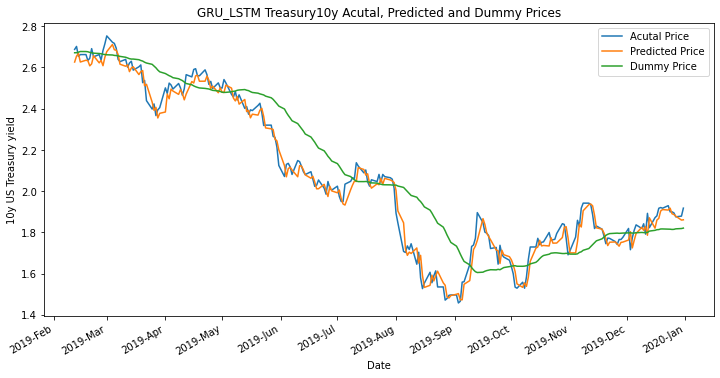

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

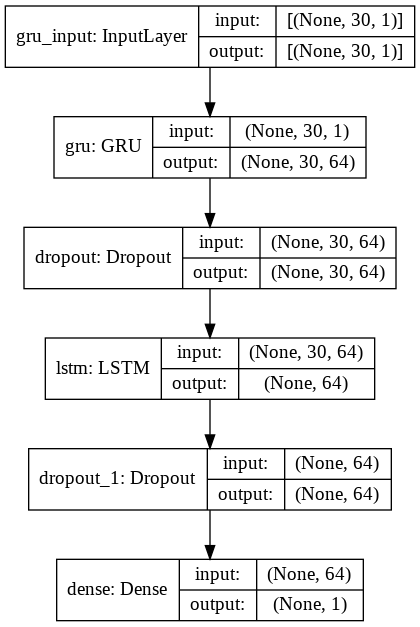

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0015989567507901845
RMSE:  0.03998695725846347
MAE:  0.03232139770484852
Dummy MSE:  0.011907945328582062
Dummy RMSE:  0.10912353242349727
Dummy MAE:  0.08287353397503001


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_LSTM_Treasury10y/assets
